Written by AI22BTECH11001

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import matplotlib.pyplot as plt

/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import torch
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate the lengths for training and validation sets
train_size = int(0.7 * len(full_train_dataset))
val_size = int(0.1 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, _ = torch.utils.data.random_split(full_train_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader)) 

1313 188 313


In [3]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

cuda
Epoch [1/3], Train Loss: 0.1393, Val Loss: 0.0491
Epoch [2/3], Train Loss: 0.0461, Val Loss: 0.0387
Epoch [3/3], Train Loss: 0.0310, Val Loss: 0.0308


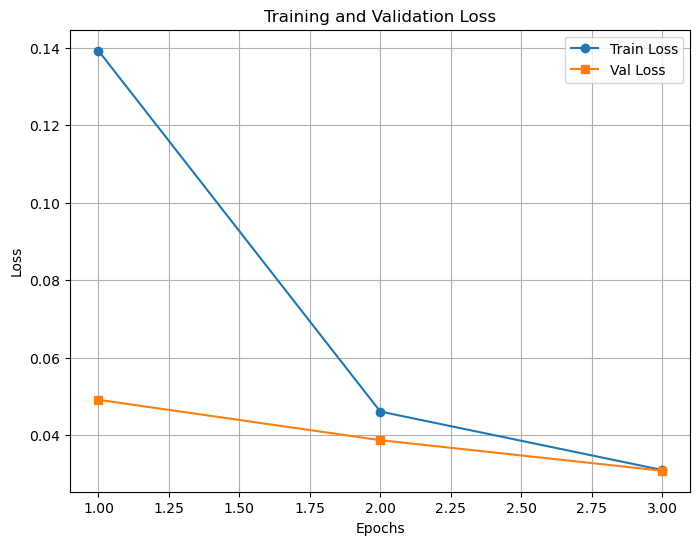

In [8]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation loss tracking
num_epochs = 3  # Set training epochs
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot training & validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Evaluate on test data
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"train Accuracy: {100 * correct / total:.2f}%")


# Evaluate on test data
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


train Accuracy: 99.51%
Test Accuracy: 98.88%


In [11]:
# Save trained model
torch.save(model.state_dict(), "mnist_cnn_lime.pth")
print("Model saved as mnist_cnn_lime.pth")

Model saved as mnist_cnn_lime.pth


In [181]:
import numpy as np
import torch

def get_samples_by_label(test_loader, num_classes=10):
    """
    Loops through the test_loader and extracts one sample per label.
    
    Args:
        test_loader (torch.utils.data.DataLoader): The test dataset loader.
        num_classes (int): Number of unique labels to collect samples for.

    Returns:
        np.ndarray: An array of shape (num_classes, 28, 28) containing one sample per class.
        list: List of corresponding labels.
    """
    samples = [None] * num_classes  # Placeholder list for each label
    labels_found = set()

    for images, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in labels_found:  # Store only if not already collected
                samples[label] = images[i].squeeze().numpy()  # Convert to (28,28)
                labels_found.add(label)

            if len(labels_found) == num_classes:  # Stop if all labels are collected
                break
        
        if len(labels_found) == num_classes:
            break

    return np.array(samples), list(labels_found)

# Get one sample per label
samples_np, labels_list = get_samples_by_label(test_loader)

print("Samples shape:", samples_np.shape)  # Expected: (10, 28, 28)
print("Labels:", labels_list)  # Expected: [0, 1, 2, ..., 9]


Samples shape: (10, 28, 28)
Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


cpu


/tmp/ipykernel_9020/2754007328.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_cnn_lime.pth", map_location=device))


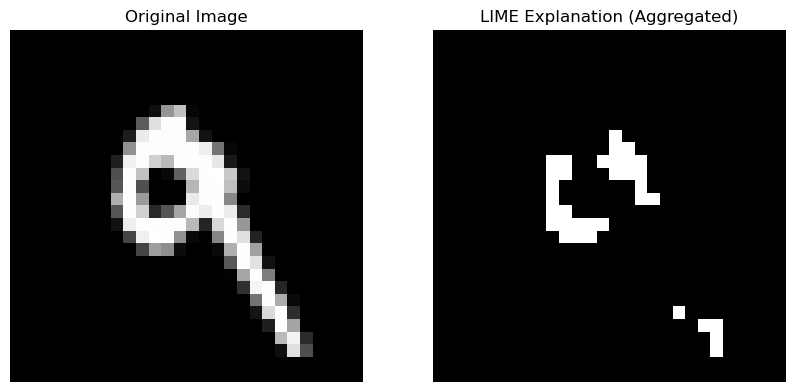

In [214]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Load model and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

# Assuming model and test_loader are already defined
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_cnn_lime.pth", map_location=device))  
model.eval()

number = 9
image = samples_np[number]
label = labels_list[number]

# Convert grayscale (1, 28, 28) to numpy (28, 28)
# image_np = image.squeeze().cpu().numpy()
image_np = image

# Function to generate perturbed samples
def generate_perturbations(image, num_samples=1000, perturb_prob=0.3):
    perturbed_images = []
    masks = []

    for _ in range(num_samples):
        mask = np.random.binomial(1, perturb_prob, image.shape)  # Binary mask
        perturbed_image = np.where(mask == 0, -0.42421296, image)  # Replace masked pixels with -0.42421296
        perturbed_images.append(perturbed_image)
        masks.append(mask)

    return np.array(perturbed_images), np.array(masks)

# Function to get model predictions
def predict_fn(images):
    images = torch.tensor(images, dtype=torch.float32).unsqueeze(1).to(device)  # Add channel dim
    with torch.no_grad():
        outputs = model(images)
    return outputs.cpu().numpy()

# **Run LIME multiple times and store binary masks**
num_runs = 20  # Number of times to repeat LIME
all_binary_masks = []

for _ in range(num_runs):
    # 1️⃣ Generate Perturbations
    perturbed_images, masks = generate_perturbations(image_np, num_samples=1000)

    # 2️⃣ Get Model Predictions
    preds = predict_fn(perturbed_images)

    # 3️⃣ Train Ridge Regression Explainer
    true_class_idx = label
    y = preds[:, true_class_idx]  # Probability of the correct class

    # Compute sample weights
    weights = np.exp(-np.linalg.norm(masks - 1, axis=(1, 2)) / 0.25)

    # Flatten masks for training
    X = masks.reshape(masks.shape[0], -1)  

    # Fit ridge regression model
    explainer = Ridge(alpha=1.0)
    explainer.fit(X, y, sample_weight=weights)

    # 4️⃣ Extract Feature Importance
    feature_importance = explainer.coef_.reshape(image_np.shape)

    # Normalize for visualization
    feature_importance = (feature_importance - feature_importance.min()) / (feature_importance.max() - feature_importance.min())

    # Set threshold for importance (e.g., top 20% most important pixels)
    threshold = np.percentile(feature_importance, 90)  # Adjust percentile as needed

    # Apply thresholding
    binary_mask = np.where(feature_importance >= threshold, 1.0, 0.0)  # White if above threshold, black otherwise

    # Store binary mask
    all_binary_masks.append(binary_mask)

# **Perform Frequency Analysis**
binary_masks_array = np.array(all_binary_masks)  # Shape: (num_runs, 28, 28)
frequency_mask = np.sum(binary_masks_array, axis=0)  # Count occurrences of important pixels

# Normalize frequency to range [0, 1] (1 = always marked important, 0 = never marked)
frequency_mask = frequency_mask / num_runs

# Threshold pixels that are frequently important (e.g., at least 60% of the runs)
final_binary_mask = np.where(frequency_mask >= 0.35, 1.0, 0.0)  # Adjust threshold as needed

# **5️⃣ Visualize Explanation**
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(image_np, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Highlight Frequently Important Regions
axes[1].imshow(final_binary_mask, cmap="gray")  # Show as pure black & white
axes[1].set_title("LIME Explanation (Aggregated)")
axes[1].axis("off")

plt.show()
